## Project Content-based approach

This approach is focussed on providing recommendations that take into consideration, the user's subjective musical preference. Working with the data we have, we try to split to users into two categories:

Strongly influenced by cultural and editorial meta-data: which we recommend based on inputted text meta-data.

Influenced more by audio features, and intrinsic properties, which we attempt to recommend based on spotify audio features and MFCC values.



### Data Loading and exploratory Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

user_listening_history = pd.read_csv('./dataset/User Listening History.csv')

#Load music info
music_info = pd.read_csv('./dataset/Music Info.csv')
style_df = pd.read_csv('./dataset/msd-MASD-styleAssignment.csv')
tags_df = pd.read_csv('./dataset/track_id_to_tags.csv')
tags_df.rename(columns={'tags':'tags_last_fm'}, inplace=True)

music_info = music_info.merge(style_df, left_on='track_id', right_on='track_id', how='left')
music_info = music_info.merge(tags_df, left_on='track_id', right_on='track_id', how='left')

In [2]:
#Add MFCC data
mfcc_data = pd.read_csv("./dataset/MSD_JMIR_MFCC_All.csv")
music_info = music_info.merge(mfcc_data, 'left', left_on='track_id', right_on='MSD_TRACKID')
music_info.drop(columns=['MSD_TRACKID'], inplace=True)

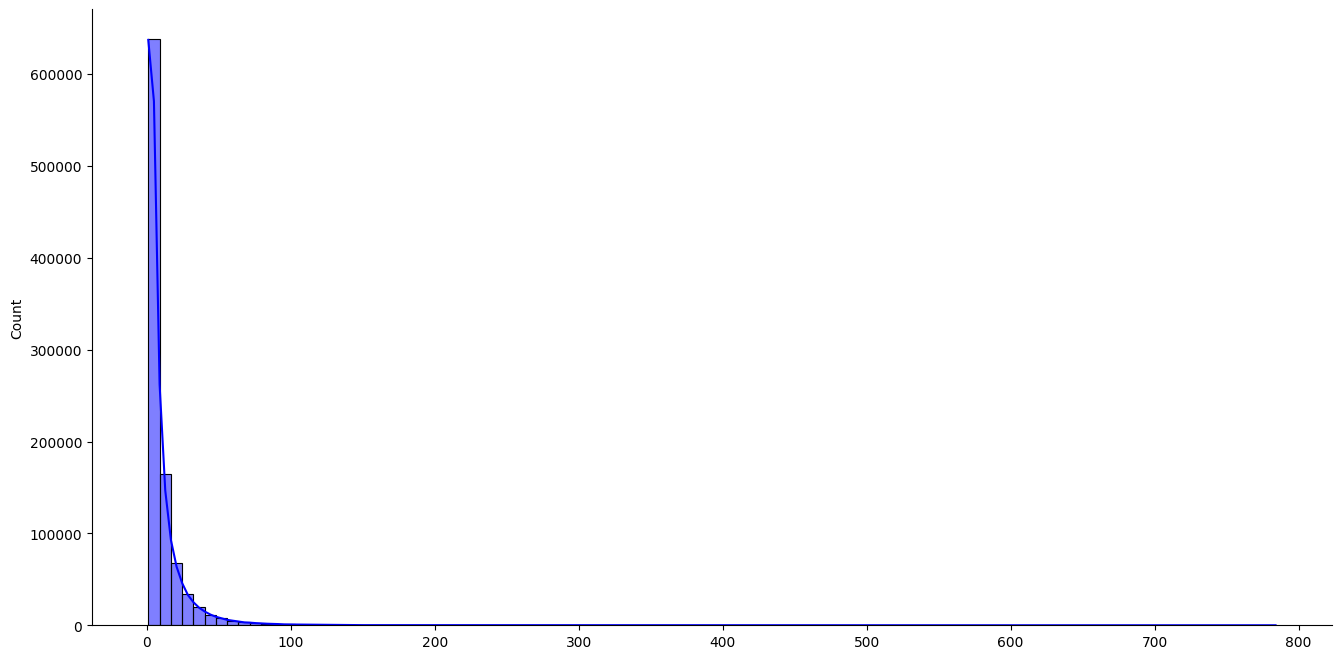

A user listens to an average of 10.094519233667729 songs
A user listens to a meadian of 5.0 songs, with minimum 1 and maximum 784 songs
The upper quartile Q3 is11.0


In [3]:

user_songs = user_listening_history.groupby('user_id')['track_id'].count()
user_songs.head()

plt.figure(figsize=(16, 8))
sns.histplot(user_songs.values, bins=100, kde=True, color='blue')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

print(f"A user listens to an average of {np.mean(user_songs)} songs")
print(f"A user listens to a meadian of {np.median(user_songs)} songs, with minimum {np.min(user_songs)} and maximum {np.max(user_songs)} songs")
print(f"The upper quartile Q3 is{np.percentile(user_songs, 75) }")

In [4]:
user_songs_dense = user_listening_history.groupby('user_id').filter(
    lambda x: x['user_id'].shape[0] >= 10)

bins = [0, 1, 2214]
user_songs_dense['ratings'] = pd.cut(user_songs_dense['playcount'], bins=bins, labels=[0, 1])
user_songs_dense.head(100)

#Filter the DataFrame for ratings of 1
rated_1_df = user_songs_dense[user_songs_dense['ratings'] == 1]

#Group by user_id and count the number of songs rated 1
user_rated_1_counts = rated_1_df.groupby('user_id').size()

#Calculate the mean, median, and range
mean_rated_1 = user_rated_1_counts.mean()
median_rated_1 = user_rated_1_counts.median()
range_rated_1 = user_rated_1_counts.max() - user_rated_1_counts.min()

# Display the results
print(f"Mean number of songs rated 1 by each user: {mean_rated_1}")
print(f"Median number of songs rated 1 by each user: {median_rated_1}")
print(f"Range of songs rated 1 by each user: {range_rated_1}")

# user_songs_dense.to_csv("user listening history rated.csv")
# # user_songs_dense = pd.read_csv("user listening history rated.csv")

Mean number of songs rated 1 by each user: 9.71573863555117
Median number of songs rated 1 by each user: 7.0
Range of songs rated 1 by each user: 219


## Data Preprocessing

Text preprocessing functions

In [5]:
import pandas as pd
import re
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as sklearn_stopwords

# Ensure the required NLTK data is downloaded
nltk.download('punkt')
nltk.download('wordnet')

ps = PorterStemmer()
wnl = WordNetLemmatizer()

def combineTextFeatures(df):
    def replaceComma(val):
        if pd.isnull(val):
            return None
        return val.replace(",", " ")

    def replaceSpace(val):
        if pd.isnull(val):
            return None
        return val.replace(" ", "-")

    df.loc[:, 'tags'] = df['tags'].apply(replaceComma)
    df.loc[:, 'artist'] = df['artist'].apply(replaceSpace)
    df.loc[:, 'name'] = df['name'].apply(replaceSpace)
    df.loc[:, 'text_content'] = df.apply(lambda row: ' '.join(row[['name', 'artist', 'tags', 'genre', 'tags_last_fm', 'style']].dropna().astype(str)), axis=1)

    return df

def preprocess_text(text, lem=None, stem=None, stop_words=[]):
    if lem and stem:
        raise ValueError("Only one of 'lem' or 'stem' can be provided, not both.")

    # Lower text
    text = text.lower()

    # Tokenize text content
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]

    if lem:
        tokens = [lem.lemmatize(token) for token in tokens]
    elif stem:
        tokens = [stem.stem(token) for token in tokens]
        
    return ' '.join(tokens)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ysaeu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ysaeu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Apply text preprocessing to music information

In [6]:
print("combining text")
music_info_preprocessed = combineTextFeatures(music_info)
print("text combined")
music_info_preprocessed['text_content_preprocessed'] = music_info['text_content'].apply(lambda x: preprocess_text(x, lem=wnl, stop_words=sklearn_stopwords))


combining text
text combined


Combine user liked songs to music info

In [7]:
user_songs_liked = user_songs_dense.loc[user_songs_dense["ratings"] == 1]
user_songs_liked_data = pd.merge(user_songs_liked, music_info_preprocessed, how='left', left_on='track_id', right_on='track_id')
user_songs_liked_data.drop(columns=["spotify_preview_url", "spotify_id"])

,track_id,user_id,playcount,ratings,name,artist,tags,genre,year,duration_ms,...,MFCC_Overall_Average_6,MFCC_Overall_Average_7,MFCC_Overall_Average_8,MFCC_Overall_Average_9,MFCC_Overall_Average_10,MFCC_Overall_Average_11,MFCC_Overall_Average_12,MFCC_Overall_Average_13,text_content,text_content_preprocessed
0,TRAAHSY128F147BB5C,b80344d063b5ccb3212f76538f3d9e43d87dca9e,2,1,Speed-of-Sound,Coldplay,rock alternative indie pop alternative_roc...,Rock,2008,287906,...,0.8203,-1.42700,1.1350,-0.9948,1.0220,-1.1360,0.98310,-0.41040,Speed-of-Sound Coldplay rock alternative ind...,speed-of-sound coldplay rock alternative indie...
1,TRNJLKP128F427CE28,b64cdd1a0bd907e5e00b39e345194768e330d652,3,1,Aerodynamic,Daft-Punk,electronic dance house techno electro french,Electronic,2001,207533,...,-1.8680,-1.97000,-0.5949,0.6808,2.6000,-0.9669,1.02200,0.27010,Aerodynamic Daft-Punk electronic dance house...,aerodynamic daft-punk electronic dance house t...
2,TRGASNY128F14696B0,b64cdd1a0bd907e5e00b39e345194768e330d652,2,1,Indo-Silver-Club,Daft-Punk,electronic instrumental dance 90s house t...,Electronic,1997,274733,...,3.2570,-0.04977,0.6374,-2.0120,0.7767,-1.9570,0.03451,-0.86700,Indo-Silver-Club Daft-Punk electronic instrum...,indo-silver-club daft-punk electronic instrume...
3,TRISTWT128F1488FBB,b64cdd1a0bd907e5e00b39e345194768e330d652,3,1,High-Life,Daft-Punk,electronic dance house techno electro french,Electronic,2001,201800,...,2.1010,-1.36900,1.7730,-1.7630,0.9196,-1.4350,0.69420,-1.15300,High-Life Daft-Punk electronic dance house ...,high-life daft-punk electronic dance house tec...
4,TRJXVFS128F14696B2,b64cdd1a0bd907e5e00b39e345194768e330d652,2,1,Funk-Ad,Daft-Punk,electronic dance 90s house techno electro...,Electronic,1997,51400,...,2.5520,-0.68770,2.1730,-0.1849,1.1400,-0.6059,0.82940,-0.42410,Funk-Ad Daft-Punk electronic dance 90s hous...,funk-ad daft-punk electronic dance 90 house te...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2717798,TRCWBAL128F934B434,cf8289419383259189afe6bb50c5115fd84f1064,8,1,Costume-Party,Two-Door-Cinema-Club,electronic alternative indie indie_rock br...,Rock,2009,207466,...,-1.7100,1.35800,0.7917,0.2151,1.0960,0.2831,0.01537,0.04089,Costume-Party Two-Door-Cinema-Club electronic ...,costume-party two-door-cinema-club electronic ...
2717799,TRIROYA12903CE1794,cf8289419383259189afe6bb50c5115fd84f1064,6,1,Something-Good-Can-Work,Two-Door-Cinema-Club,rock electronic alternative indie pop ind...,Rock,2010,164200,...,-0.5890,0.76090,0.6289,0.9792,0.7345,-0.0539,-0.31020,0.04698,Something-Good-Can-Work Two-Door-Cinema-Club r...,something-good-can-work two-door-cinema-club r...
2717800,TREXRBN128F42676B8,cf8289419383259189afe6bb50c5115fd84f1064,7,1,So-Says-I,The-Shins,rock alternative indie pop indie_rock ind...,Rock,2003,167946,...,1.3420,-1.43900,1.7170,-0.1809,1.3040,-1.4300,0.47640,-0.90070,So-Says-I The-Shins rock alternative indie ...,so-says-i the-shins rock alternative indie pop...
2717801,TRHKUHY128F425A0AA,cf8289419383259189afe6bb50c5115fd84f1064,12,1,Heldenzeit,Wir-sind-Helden,rock pop german pop_rock,NaN,2003,263960,...,2.7150,-0.88880,0.7316,-0.6508,1.4810,-1.5640,0.28820,-1.29000,Heldenzeit Wir-sind-Helden rock pop german ...,heldenzeit wir-sind-helden rock pop german pop...


Define the Tf-IDF vectorizer and fit it to all preprocessed text data

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfIdfVectorizer = TfidfVectorizer(stop_words = 'english')
tfIdfVectorizer.fit(music_info_preprocessed['text_content_preprocessed'])

TfidfVectorizer(stop_words='english')

### Fit models
Fit text based models

In [27]:
from numpy import sqrt
from sklearn.neighbors import NearestNeighbors

# Options           
text_column='text_content_preprocessed' 
id_column='track_id'

if text_column not in music_info_preprocessed.columns:
    raise ValueError(f"Column '{text_column}' not found in DataFrame")

if id_column not in music_info_preprocessed.columns:
    raise ValueError(f"Column '{id_column}' not found in DataFrame")

num_neighbors = round(sqrt(len(music_info_preprocessed)))


tfidf_matrix = tfIdfVectorizer.transform(music_info_preprocessed[text_column])
text_knn_model = NearestNeighbors(n_neighbors=num_neighbors, metric='cosine')
text_knn_model.fit(tfidf_matrix)

NearestNeighbors(metric='cosine', n_neighbors=225)

Fit Audio based model

In [28]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
music_info_preprocessed.fillna(0, inplace=True)
numerical_features = ['valence', 'tempo'] + [f'MFCC_Overall_Average_{i}' for i in range(1, 14)]
music_info_preprocessed[numerical_features] = scaler.fit_transform(music_info_preprocessed[numerical_features])

# Define numerical features
numerical_features = ['valence', 'tempo'] + [f'MFCC_Overall_Average_{i}' for i in range(1, 14)]
numerical_features_df = music_info_preprocessed[numerical_features]


scaler = StandardScaler()
scaled_numerical_features = scaler.fit_transform(numerical_features_df)


# Train KNN model
num_neighbors = round(sqrt(len(scaled_numerical_features)))
audio_knn_model = NearestNeighbors(n_neighbors=num_neighbors, algorithm='auto')
audio_knn_model.fit(scaled_numerical_features)

NearestNeighbors(n_neighbors=225)

### Perform user classification

Split users so they either get recommended from text data or audio features

In [11]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import numpy as np

def get_user_liked_text_similarity_mean(tf_idf_vecotizer, user_liked_songs_subset):

    # Fit the vectorizer on the text_content_preprocessed and transform the data
    tfidf_matrix = tf_idf_vecotizer.transform(user_liked_songs_subset['text_content_preprocessed'])

    # Compute pairwise cosine similarity
    cosine_similarities = cosine_similarity(tfidf_matrix)

    # Extract off-diagonal elements
    n = cosine_similarities.shape[0]
    mask = ~np.eye(n, dtype=bool)  # Mask to ignore diagonal
    off_diagonal_elements = cosine_similarities[mask]

    # Compute the average of the off-diagonal elements
    return np.mean(off_diagonal_elements)


In [12]:
import sys
#Compute metadata similarity for all users
def getAllUsersTextSimilarity(user_songs_data, tf_idf_vectorizer):
    results = []

    # Group by user_id and apply the processing function
    grouped = user_songs_data.groupby("user_id")
    total_users = len(grouped)

    for iteration, (user_id, group) in enumerate(grouped, start=1):
        text_similarity = get_user_liked_text_similarity_mean(tf_idf_vecotizer=tf_idf_vectorizer, user_liked_songs_subset=group)
        result = {"user_id": user_id, "text_similarity": text_similarity}
        results.append(result)
        # Print progress
        percentage = (iteration / total_users) * 100
        sys.stdout.write(f'\r{percentage:.2f}% Complete. This is iteration: {iteration}')
        sys.stdout.flush()
    print("\nconverting results to df...\n")
    # Concatenate all results into a single DataFrame
    result_df = pd.DataFrame(results)
    return result_df

# Step 1: Filter out users with fewer than 10 entries
user_counts = user_songs_liked_data.groupby('user_id')['track_id'].transform('count')
filtered_by_user_count = user_songs_liked_data[user_counts >= 10]

# Step 2: Sort by 'playcount' in descending order
filtered_by_user_count_sorted = filtered_by_user_count.sort_values(by='playcount', ascending=False)

# Step 3: Group by 'user_id' and take the top 10 rows per user
user_songs_liked_data_filtered = filtered_by_user_count_sorted.groupby('user_id').head(5)


# user_preferrence_features_unscaled = getAllUsersTextSimilarity(user_songs_liked_data_filtered, tfIdfVectorizer)
# # user_preferrence_features.to_csv("user_preference_features_text.csv")


In [13]:
# Saves output to speed up experimentation
# user_preferrence_features_unscaled.to_csv("user_preference_features_text.csv")
user_preferrence_features_unscaled = pd.read_csv("user_preference_features_text.csv")


count    101561.000000
mean          0.128766
std           0.127431
min           0.000000
25%           0.040084
50%           0.084097
75%           0.173479
max           0.827909
Name: text_similarity, dtype: float64
Median value is:  0.0840970428087605


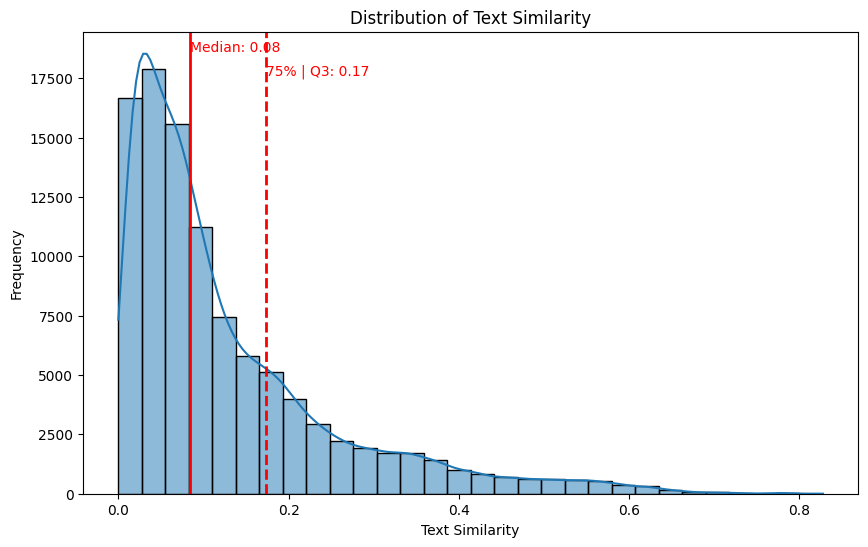

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# user_preferrence_features_unscaled = pd.read_csv("user_preference_features_text.csv")
user_preferrence_features = user_preferrence_features_unscaled.copy()

print(user_preferrence_features["text_similarity"].describe())
text_similarity_median = user_preferrence_features["text_similarity"].median()
text_similarity_upper_q = user_preferrence_features["text_similarity"].quantile(q=0.75)
text_similarity_low_q = user_preferrence_features["text_similarity"].quantile(q=0.25)

print("Median value is: ", text_similarity_median)


# Assuming user_preferrence_features is a DataFrame with a column 'text_similarity'
# user_preferrence_features = pd.DataFrame(...) # Your DataFrame definition

# Plotting the histogram
plt.figure(figsize=(10, 6))
sns.histplot(user_preferrence_features["text_similarity"], bins=30, kde=True)


# Adding a line and label for the median value
plt.axvline(text_similarity_median, color='r', linestyle='-', linewidth=2)
median_y_position = plt.gca().get_ylim()[1] * 0.95
plt.text(text_similarity_median, median_y_position, f'Median: {text_similarity_median:.2f}', color='r', verticalalignment='bottom')

# Adding a line and label for the Q3 value
plt.axvline(text_similarity_upper_q, color='r', linestyle='--', linewidth=2)
q3_y_position = plt.gca().get_ylim()[1] * 0.9
plt.text(text_similarity_upper_q, q3_y_position, f'75% | Q3: {text_similarity_upper_q:.2f}', color='r', verticalalignment='bottom')

# Adding labels and title
plt.xlabel("Text Similarity")
plt.ylabel("Frequency")
plt.title("Distribution of Text Similarity")

# Showing the plot
plt.show()


In [93]:
# Define a threshold to split uses who can be recommended via text similarity
# threshold = text_similarity_upper_q
threshold = text_similarity_low_q
user_preferrence_features["text_similarity_threshold"] = user_preferrence_features["text_similarity"].apply(lambda x: x > threshold)

user_preferrence_features

,Unnamed: 0,user_id,text_similarity,text_similarity_threshold
0,0,0000f88f8d76a238c251450913b0d070e4a77d19,0.106365,False
1,1,00028f3cff4872bff3e9985cfa32e01a8d54e374,0.068819,False
2,2,0002c1572d25df132b05510e97c55c51e04e65f1,0.201324,True
3,3,0002e94348b2543c6e6ccf408b0160d14064e46f,0.067490,False
4,4,00038cf792e9f9a1cb593dea5779f96195aac68c,0.155910,False
...,...,...,...,...
101556,101556,fffdd827deaff2db3582b0f0e335713e74d732b2,0.267302,True
101557,101557,ffff6f29052de81f5720b1ccf4ee41457d0fd5e8,0.009452,False
101558,101558,ffff9de9f9ab522578ff9f1b188def1b7375a68f,0.033680,False
101559,101559,ffffcfeb0c1b66bd212ea58d918c7dc62fb9c3a5,0.021217,False


In [94]:
user_profiles = pd.merge(user_songs_liked_data_filtered, user_preferrence_features, on='user_id')
user_profiles

,track_id,user_id,playcount,ratings,name,artist,spotify_preview_url,spotify_id,tags,genre,...,MFCC_Overall_Average_9,MFCC_Overall_Average_10,MFCC_Overall_Average_11,MFCC_Overall_Average_12,MFCC_Overall_Average_13,text_content,text_content_preprocessed,Unnamed: 0,text_similarity,text_similarity_threshold
0,TRGIEHQ128F14668E3,944cdf52364f45b0edd1c972b5a73d3a86b09c6a,1862,1,Pepper,Butthole-Surfers,https://p.scdn.co/mp3-preview/90f2f00b377ba6ad...,1ng36571Iyov4HBxUClySn,rock alternative alternative_rock experimen...,Rock,...,0.11780,1.981000,-0.1109,1.23500,-0.81090,Pepper Butthole-Surfers rock alternative alt...,pepper butthole-surfers rock alternative alter...,58689,0.071996,False
1,TRWQQNK128F425A335,af3ee32357049dd96231238bd1b019e8142ee6aa,1467,1,Thinking-About-Tomorrow,Beth-Orton,https://p.scdn.co/mp3-preview/839c12cb4f568e1f...,2OLuNNKTliuBcRaO36VaZW,alternative female_vocalists folk singer_so...,NaN,...,0.85980,-0.100100,-0.3099,0.21360,-0.67010,Thinking-About-Tomorrow Beth-Orton alternative...,thinking-about-tomorrow beth-orton alternative...,69482,0.067690,False
2,TRIPOXP128F9303609,3eef9b511ae8b3bcf6adf0bccc6547b55bc447b2,1460,1,The-Bell,Mike-Oldfield,https://p.scdn.co/mp3-preview/e51a93277bfd8580...,0tt1ObIvlN6HHSl9L4URz1,instrumental progressive_rock new_age,Rock,...,-0.93100,0.753800,-0.4463,0.04825,-0.69510,The-Bell Mike-Oldfield instrumental progressi...,the-bell mike-oldfield instrumental progressiv...,24817,0.117853,False
3,TRBNDWW12903D05C98,0f5035eac07744d23719c8ba7a537d7eaadb3e71,1336,1,Letters-From-The-Sky,Civil-Twilight,https://p.scdn.co/mp3-preview/38c232f6f1ff16bc...,07TRuPZ8NagRaMpOd2lvVz,indie soundtrack piano male_vocalists love...,Rock,...,-0.71250,0.874300,-0.4001,0.24620,-0.81490,Letters-From-The-Sky Civil-Twilight indie sou...,letters-from-the-sky civil-twilight indie soun...,5916,0.066830,False
4,TRWVOJJ12903CCC654,82fed477acd885cc428c29f1423f1929582d0643,1135,1,My-Immortal,Evanescence,https://p.scdn.co/mp3-preview/1d1e3814d3256397...,0ftNFLfm5CaVQtJCK0w2L5,rock alternative female_vocalists metal al...,Rock,...,-1.26400,0.831200,-1.5850,1.04500,-0.74870,My-Immortal Evanescence rock alternative fem...,my-immortal evanescence rock alternative femal...,51900,0.081362,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507800,TROUMHD128F9355B89,0be3ce1acf6cf348b363a3e6cf03bb3615348afc,2,1,Obsessions,Marina-&-the-Diamonds,https://p.scdn.co/mp3-preview/e3c070cb42e1413b...,0X3VdkebZGTuL9sMOMoyHy,indie pop female_vocalists singer_songwrite...,Pop,...,-0.86080,0.006644,-0.7791,0.23290,-0.78820,Obsessions Marina-&-the-Diamonds indie pop f...,obsession marina- & -the-diamonds indie pop fe...,4607,0.133880,False
507801,TRZJFZJ128F92D425E,7f732336b4d771e11a8cbac9da24bbce84a7fe25,2,1,Like-A-Boss,Slim-Thug,https://p.scdn.co/mp3-preview/124b10ae59a459df...,16Iu6x1MoxZ0SANXZ5pNuR,rap hip_hop,Rap,...,-0.02625,1.229000,0.3570,-0.08095,0.47850,Like-A-Boss Slim-Thug rap hip_hop Rap,like-a-boss slim-thug rap hip_hop rap,50564,0.137087,False
507802,TRSNEMA128F92F279A,7f732336b4d771e11a8cbac9da24bbce84a7fe25,2,1,Space-Olympics,The-Lonely-Island,https://p.scdn.co/mp3-preview/3d1ae5802c073af4...,2TvuR9sbolLCusuyNDrkcr,None,NaN,...,-0.93000,0.952300,-0.9742,-0.74980,-0.43960,Space-Olympics The-Lonely-Island,space-olympics the-lonely-island,50564,0.137087,False
507803,TRTGXPW128F92F278E,7f732336b4d771e11a8cbac9da24bbce84a7fe25,2,1,Sax-Man,The-Lonely-Island,https://p.scdn.co/mp3-preview/c1459406bfca1858...,1AdCHY8ZSES6oxy92QizbA,funk 00s,NaN,...,0.15370,0.692800,-0.1928,0.32940,-0.44480,Sax-Man The-Lonely-Island funk 00s,sax-man the-lonely-island funk 00s,50564,0.137087,False


### Perform recommendations

In [95]:




def recommendSongForUser(text_knn_model, audio_knn_model, user_id, user_profiles, user_preferrence_features, total_recommendations, track_id_to_index):

    test_user_profile = user_profiles.loc[user_profiles["user_id"] == user_id]
    user_preference_is_text = user_preferrence_features.loc[user_preferrence_features["user_id"] == user_id, "text_similarity_threshold"].item()
    recommendation_model = text_knn_model if user_preference_is_text else audio_knn_model


    recommendations = []
    liked_track_ids = set(test_user_profile['track_id'])

    # Track IDs to consider for recommendations
    all_recommendations = {}
    all_recommendations_set = set()

    for track_id in test_user_profile['track_id']:
        track_index = track_id_to_index[track_id]

        if (user_preference_is_text):
            tfIdfVector = tfIdfVectorizer.transform(music_info_preprocessed.loc[music_info_preprocessed["track_id"] == track_id,  "text_content_preprocessed"])
            distances, indices = recommendation_model.kneighbors(tfIdfVector)
        else:
            track_features = scaled_numerical_features[track_index].reshape(1, -1)
            distances, indices = recommendation_model.kneighbors(track_features)

        recommended_indices = indices[0][1:]  # Skip the first one (self-match)
        recommended_tracks = music_info_preprocessed.iloc[recommended_indices]['track_id'].values

        for rec_track_id in recommended_tracks:
            if rec_track_id not in liked_track_ids and rec_track_id not in all_recommendations_set:
                all_recommendations[rec_track_id] = track_id
                all_recommendations_set.add(track_id)
                if len(all_recommendations) >= total_recommendations:
                    break
        if len(all_recommendations) >= total_recommendations:
            break

    # Add recommendations to the list
    recommendations.extend({
        'user_id': user_id,
        'song_used_track_id': song_used_track_id,
        'track_id': rec_track_id
    } for rec_track_id, song_used_track_id in all_recommendations.items())

    return recommendations




In [96]:
user_profiles.loc[user_profiles["user_id"] == "5a905f000fc1ff3df7ca807d57edb608863db05d"]

,track_id,user_id,playcount,ratings,name,artist,spotify_preview_url,spotify_id,tags,genre,...,MFCC_Overall_Average_9,MFCC_Overall_Average_10,MFCC_Overall_Average_11,MFCC_Overall_Average_12,MFCC_Overall_Average_13,text_content,text_content_preprocessed,Unnamed: 0,text_similarity,text_similarity_threshold
20156,TRISMJG128E07989DA,5a905f000fc1ff3df7ca807d57edb608863db05d,28,1,Sé-Lest,Sigur-Rós,https://p.scdn.co/mp3-preview/58b7df226989f88b...,4GcNCgQa1X3mTHYZ9zNVqT,alternative indie ambient experimental chi...,NaN,...,0.8542,2.8790,-0.9709,1.6250,1.114000,Sé-Lest Sigur-Rós alternative indie ambient ...,sé-lest sigur-rós alternative indie ambient ex...,35911,0.53438,True
51342,TRBHUYM128E07989DB,5a905f000fc1ff3df7ca807d57edb608863db05d,18,1,Sæglópur,Sigur-Rós,https://p.scdn.co/mp3-preview/6ed037cf5324f533...,23gvOOyvzeKNvKdwj34jT3,electronic alternative indie ambient exper...,NaN,...,-0.8644,1.6640,-0.4349,0.7305,-0.615600,Sæglópur Sigur-Rós electronic alternative in...,sæglópur sigur-rós electronic alternative indi...,35911,0.53438,True
52795,TRFOCFY128E07989DD,5a905f000fc1ff3df7ca807d57edb608863db05d,17,1,Gong,Sigur-Rós,https://p.scdn.co/mp3-preview/d070acba357a00b7...,1ZjQgM7HHjv5EjE05dOEMq,electronic alternative indie ambient exper...,NaN,...,-1.3890,0.4088,-1.1170,1.4400,0.006475,Gong Sigur-Rós electronic alternative indie ...,gong sigur-rós electronic alternative indie am...,35911,0.53438,True
55333,TRTDLDY12903CF7FF7,5a905f000fc1ff3df7ca807d57edb608863db05d,17,1,Andvari,Sigur-Rós,https://p.scdn.co/mp3-preview/3bb7d0e4a4071b32...,0EdCt9PpsDneh4LeNIy5vp,alternative indie ambient experimental chi...,NaN,...,-0.2982,-0.2820,-0.2613,0.6323,-0.923700,Andvari Sigur-Rós alternative indie ambient ...,andvari sigur-rós alternative indie ambient ex...,35911,0.53438,True
63885,TRLQUGG128F4261B0E,5a905f000fc1ff3df7ca807d57edb608863db05d,16,1,Olsen-Olsen,Sigur-Rós,https://p.scdn.co/mp3-preview/b91793812971b6f2...,00LlKWWT70NKLbRf4PfSi4,alternative indie ambient experimental ins...,Rock,...,-1.1150,1.5580,-0.9233,-0.1091,-0.674100,Olsen-Olsen Sigur-Rós alternative indie ambi...,olsen-olsen sigur-rós alternative indie ambien...,35911,0.53438,True


### Evaluation

The evaluation process follows this methodology:

- extract a dense subset of users, who have each listened to more than 180 songs.
- randomly hide half of their playcounts, this is done with a random seed for reproducability

... After recommendation system is defined 


reintroduce the hidden 50 playcounts

For each in dense_subset:

- Count topN based on hit_rate_low_intent (playcount >= 1)
- Count topN based on hit_rate_low_intent (playcount == 1)
- Count topN based on hit_rate_favourite_genre 






In [97]:
# Load evaluation test set
evaluation_users = pd.read_csv("./dataset/UserDense180Split.csv")
evaluation_users


,Unnamed: 0,track_id,user_id,playcount,split
0,79875,TRCKPSF128F148A1B1,0037cbbc2cd55e2ba6d6839b15175522339aadec,1,train
1,79871,TRKDHEQ128E0791264,0037cbbc2cd55e2ba6d6839b15175522339aadec,2,train
2,79789,TRWCEKE128F93191BE,0037cbbc2cd55e2ba6d6839b15175522339aadec,4,train
3,79727,TRDDJYF12903CFB066,0037cbbc2cd55e2ba6d6839b15175522339aadec,1,train
4,79752,TRCQPPA128F423EA73,0037cbbc2cd55e2ba6d6839b15175522339aadec,1,train
...,...,...,...,...,...
81882,9941,TRXRBYB128F93471D5,fef771ab021c200187a419f5e55311390f850a50,2,test
81883,9814,TRUSKBC128E0791E6A,fef771ab021c200187a419f5e55311390f850a50,1,test
81884,9723,TRPDRWH128F148DAC3,fef771ab021c200187a419f5e55311390f850a50,2,test
81885,9696,TRRQBED128F4279305,fef771ab021c200187a419f5e55311390f850a50,3,test


In [98]:

filtered_user_profiles = filtered_by_user_count_sorted[filtered_by_user_count_sorted["user_id"].isin(evaluation_users["user_id"].unique())]
iteration = 0
filtered_groups = []
for user_id, group in filtered_user_profiles.groupby("user_id"):
    user_train_songs = evaluation_users.loc[evaluation_users["user_id"] == user_id]
    user_train_songs = user_train_songs.loc[user_train_songs["split"] == "train"]
    filtered_group = group[group["track_id"].isin(user_train_songs["track_id"].unique())]
    filtered_groups.append(filtered_group)
    
test_user_song_mappings = pd.concat(filtered_groups)
test_user_song_mappings = test_user_song_mappings.groupby('user_id').head(5)


filtered_user_preferrence_features = user_preferrence_features[user_preferrence_features["user_id"].isin(evaluation_users["user_id"].unique())]

In [99]:
total_recommendations = 10
track_id_to_index = {track_id: idx for idx, track_id in enumerate(music_info_preprocessed['track_id'])}

recommendations = []

iteration = 0
total_users = test_user_song_mappings["user_id"].nunique()
for user in test_user_song_mappings["user_id"].unique():

    recommendations_for_user = recommendSongForUser(text_knn_model=text_knn_model, 
                        audio_knn_model=audio_knn_model, 
                        user_profiles=test_user_song_mappings,
                        user_id=user, 
                        user_preferrence_features=filtered_user_preferrence_features,
                        total_recommendations=total_recommendations,
                        track_id_to_index = track_id_to_index)
    recommendations.extend(recommendations_for_user)
    iteration += 1
    percentage = (iteration / total_users) * 100
    sys.stdout.write(f'\r{percentage:.2f}% Complete. This is iteration: {iteration}')
    sys.stdout.flush()

recommendations_df = pd.DataFrame(recommendations)
recommendations_df

0.27% Complete. This is iteration: 1

100.00% Complete. This is iteration: 372

,user_id,song_used_track_id,track_id
0,0037cbbc2cd55e2ba6d6839b15175522339aadec,TRWCEKE128F93191BE,TRUZLSY12903CD8866
1,0037cbbc2cd55e2ba6d6839b15175522339aadec,TRWCEKE128F93191BE,TRLWTFH12903CFECC9
2,0037cbbc2cd55e2ba6d6839b15175522339aadec,TRWCEKE128F93191BE,TRXFWQG12903CBAD9B
3,0037cbbc2cd55e2ba6d6839b15175522339aadec,TRWCEKE128F93191BE,TRFCKJT128E078E9AB
4,0037cbbc2cd55e2ba6d6839b15175522339aadec,TRWCEKE128F93191BE,TRLKLHH128F425B79D
...,...,...,...
3715,fef771ab021c200187a419f5e55311390f850a50,TRZXQVN128E0782857,TRORFWA128F425ACC9
3716,fef771ab021c200187a419f5e55311390f850a50,TRZXQVN128E0782857,TRJUIBH128E0793AF1
3717,fef771ab021c200187a419f5e55311390f850a50,TRZXQVN128E0782857,TRCQUWE128F427EF8F
3718,fef771ab021c200187a419f5e55311390f850a50,TRZXQVN128E0782857,TRMPBFA128EF33FB7E


In [100]:
user_fav_genres = pd.read_csv("./dataset/test_user_fav_genre.csv")

# Calculate top N playcount >= 1
test_set = evaluation_users.loc[evaluation_users["split"] == "test"]

recommendations_to_test = recommendations_df.merge(test_set, "left", on=["user_id", "track_id"])
truePositiveAtNOverall = recommendations_to_test["split"].count()

precisionAtN = truePositiveAtNOverall/len(recommendations_to_test)
recallAtN = truePositiveAtNOverall/len(evaluation_users)
f1AtN = (2*precisionAtN*recallAtN)/(precisionAtN+recallAtN)
print("Low-intent (playcount >= 1) Top N metrics")
print("Precision@N: ", precisionAtN * 100)
print("recall@N: ", recallAtN * 100)
print("f1@N: ", f1AtN * 100)

# Calculate the number of true positives for each user
user_true_positives = recommendations_to_test.groupby("user_id")["split"].count()

# Count how many users have each specific number of true positives
true_positive_counts = user_true_positives.value_counts().sort_index()

# Create a new DataFrame with the results
lowIntentResults = pd.DataFrame({
    "number_of_true_positives": true_positive_counts.index,
    "number_of_users": true_positive_counts.values
})

print()
## high intent
test_set = evaluation_users.loc[evaluation_users["split"] == "test"]
test_set = test_set.loc[test_set["playcount"] > 1]
recommendations_to_test = recommendations_df.merge(test_set, "left", on=["user_id", "track_id"])
truePositiveAtNOverall = recommendations_to_test["split"].count()

if (len(recommendations_to_test) > 0):
    print("here")
    print(len(recommendations_to_test) )
    print(truePositiveAtNOverall )

    precisionAtN = truePositiveAtNOverall/len(recommendations_to_test)
    recallAtN = truePositiveAtNOverall/len(evaluation_users)
else:
    precisionAtN = 0
    recallAtN = 0
f1AtN = (2*precisionAtN*recallAtN)/(precisionAtN+recallAtN)
print("High-intent (playcount >= 1) Top N metrics")
print("Precision@N: ", precisionAtN* 100)
print("recall@N: ", recallAtN * 100)
print("f1@N: ", f1AtN * 100)

# Calculate the number of true positives for each user
user_true_positives = recommendations_to_test.groupby("user_id")["split"].count()

# Count how many users have each specific number of true positives
true_positive_counts = user_true_positives.value_counts().sort_index()

# Create a new DataFrame with the results
highIntent = pd.DataFrame({
    "number_of_true_positives": true_positive_counts.index,
    "number_of_users": true_positive_counts.values
})

# Merge recommendations with music information and user favorite genres
recommendations_with_genre = recommendations_df.merge(music_info_preprocessed, on="track_id", how="left")
recommendations_with_genre = recommendations_with_genre.merge(user_fav_genres, on="user_id", how="left")
recommendations_with_genre = recommendations_with_genre[["user_id", "track_id", "genre", "favourite_genre"]]

# Calculate true positives where the genre matches the user's favorite genre
truePositives = recommendations_with_genre.loc[recommendations_with_genre["genre"] == recommendations_with_genre["favourite_genre"]]

# Calculate the number of true positives for each user
user_genre_true_positives = truePositives.groupby("user_id").size()

# Count how many users have each specific number of true positives
true_positive_counts = user_genre_true_positives.value_counts().sort_index()

# Create a new DataFrame with the results
genreResults = pd.DataFrame({
    "number_of_genre_true_positives": true_positive_counts.index,
    "number_of_users": true_positive_counts.values
})

# Calculate and print genre precision
truePositivesGenreCount = len(truePositives)
genreHits = truePositivesGenreCount / len(recommendations_with_genre)
print("genre hit rate: ", genreHits*100)
genreResults.to_csv('./evaluation/genreHits_low_threshold.csv')
lowIntentResults.to_csv('./evaluation/lowIntentHits_low_threshold.csv')
highIntent.to_csv('./evaluation/highIntentHits_low_threshold.csv')


Low-intent (playcount >= 1) Top N metrics
Precision@N:  3.6290322580645165
recall@N:  0.16486133330076813
f1@N:  0.31539476911934766



here
3720
110
High-intent (playcount >= 1) Top N metrics
Precision@N:  2.956989247311828
recall@N:  0.13433145676358885
f1@N:  0.25698833039354263
genre hit rate:  22.876344086021504


In [101]:

recommendationsPerK = []
for i in range(1,11):
    total_recommendations = 10 * i
    track_id_to_index = {track_id: idx for idx, track_id in enumerate(music_info_preprocessed['track_id'])}

    recommendations = []

    iteration = 0
    total_users = test_user_song_mappings["user_id"].nunique()
    for user in test_user_song_mappings["user_id"].unique():

        recommendations_for_user = recommendSongForUser(text_knn_model=text_knn_model, 
                            audio_knn_model=audio_knn_model, 
                            user_profiles=test_user_song_mappings,
                            user_id=user, 
                            user_preferrence_features=filtered_user_preferrence_features,
                            total_recommendations=total_recommendations,
                            track_id_to_index = track_id_to_index)
        recommendations.extend(recommendations_for_user)
        iteration += 1
        percentage = (iteration / total_users) * 100
        sys.stdout.write(f'\r{percentage:.2f}% Complete. This is iteration: {iteration}, for k = {total_recommendations}')
        sys.stdout.flush()

    recommendations_df = pd.DataFrame(recommendations)
    recommendationsPerK.append(recommendations_df)




100.00% Complete. This is iteration: 372, for k = 100

In [102]:
genre_hit_rates = []

for results in recommendationsPerK:
    recommendations_with_genre = results.merge(music_info_preprocessed, on="track_id", how="left")
    recommendations_with_genre = recommendations_with_genre.merge(user_fav_genres, on="user_id", how="left")
    recommendations_with_genre = recommendations_with_genre[["user_id", "track_id", "genre", "favourite_genre"]]

    # Calculate true positives where the genre matches the user's favorite genre
    truePositives = recommendations_with_genre.loc[recommendations_with_genre["genre"] == recommendations_with_genre["favourite_genre"]]

    # Calculate the number of true positives for each user
    user_genre_true_positives = truePositives.groupby("user_id").size()


    # Calculate and print genre precision
    truePositivesGenreCount = len(truePositives)
    genreHits = truePositivesGenreCount / len(recommendations_with_genre)
    genre_hit_rates.append(genreHits*100)
    print("genre hit rate: ", genreHits*100)

print(genre_hit_rates)

genre hit rate:  22.876344086021504
genre hit rate:  22.822580645161292
genre hit rate:  22.804659498207887
genre hit rate:  23.0241935483871
genre hit rate:  23.059139784946236
genre hit rate:  23.28405017921147
genre hit rate:  23.456221198156683
genre hit rate:  23.343413978494624
genre hit rate:  23.390083632019117
genre hit rate:  23.489247311827956
[22.876344086021504, 22.822580645161292, 22.804659498207887, 23.0241935483871, 23.059139784946236, 23.28405017921147, 23.456221198156683, 23.343413978494624, 23.390083632019117, 23.489247311827956]


In [103]:
# Your list of values
values = genre_hit_rates

# Creating the 'k' column with values incremented by 10
k_values = list(range(10, 10 * len(values) + 1, 10))

# Creating the DataFrame
results_genre = pd.DataFrame({'k': k_values, 'values': values})
results_genre.to_csv("./evaluation/genre_per_k_medium_threshold.csv")

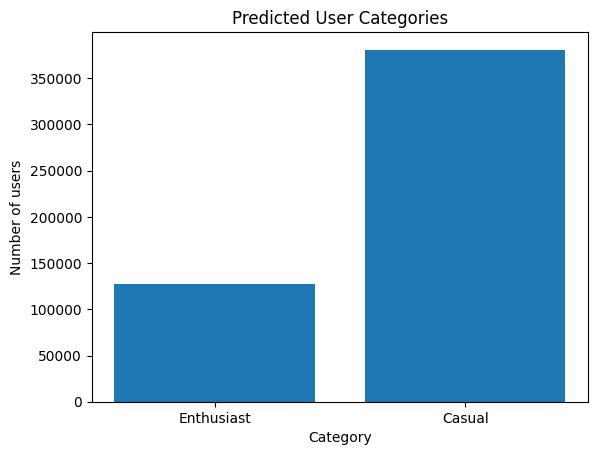

In [105]:
user_profiles


# Separate the data based on the condition
true_values = user_profiles[user_profiles['text_similarity_threshold'] == True]
false_values = user_profiles[user_profiles['text_similarity_threshold'] == False]

# Aggregating the data (e.g., sum, mean)
true_sum = len(true_values)
false_sum = len(false_values)

# Create the bar plot
labels = ['Enthusiast', 'Casual']
values = [true_sum, false_sum]

plt.bar(labels, values)
plt.xlabel('Category')
plt.ylabel('Number of users')
plt.title('Predicted User Categories')
plt.show()